# RFM Model

In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import zipfile37 as zipfile

In [2]:
from dateutil.relativedelta import relativedelta

In [3]:
ecomm = pd.read_csv('data.csv',
                    encoding='ISO-8859-1')

In [4]:
# InvoiceDate to datetime format
ecomm['InvoiceDate'] = pd.to_datetime(ecomm.InvoiceDate)

In [5]:
print('{:,} rows; {:,} columns'.format(len(ecomm),
                                       len(ecomm.columns)))

print('{:,}, null CustomerIDs'.format(sum(ecomm.CustomerID.isnull())))

print('Invoice dates range from {} to {}'.format(ecomm.InvoiceDate.min(),
                                                 ecomm.InvoiceDate.max()))

541,909 rows; 8 columns
135,080, null CustomerIDs
Invoice dates range from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [6]:
ecomm.dropna()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


## Begin Recency, Frequency, Monetary Sorting

In [7]:
# Snapshot date as day after max date
snapshot_date = ecomm.InvoiceDate.max() + relativedelta(days=1)
print(snapshot_date)

2011-12-10 12:50:00


In [8]:
ecomm['GrossSales'] = ecomm.Quantity * ecomm.UnitPrice

In [9]:
rfm_vals = ecomm.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'GrossSales': 'sum'
})
rfm_vals.rename(columns={'InvoiceDate':'Recency',
                         'InvoiceNo':'Frequency',
                         'GrossSales':'MonetaryValue'},
                inplace=True)

In [10]:
print(rfm_vals.head(5))
print('{:,} rows and {:,} columns'.format(len(rfm_vals),
                                          len(rfm_vals.columns)))

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346.0         326          2           0.00
12347.0           2        182        4310.00
12348.0          75         31        1797.24
12349.0          19         73        1757.55
12350.0         310         17         334.40
4,372 rows and 3 columns


### Take a look at distributions

<AxesSubplot:xlabel='Recency', ylabel='Density'>

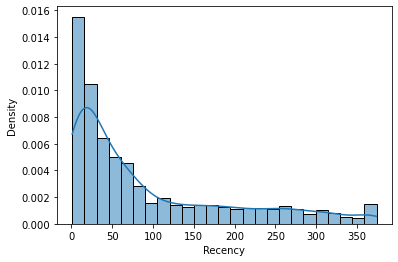

In [11]:
sns.histplot(rfm_vals['Recency'], 
            kde=True, stat='density')

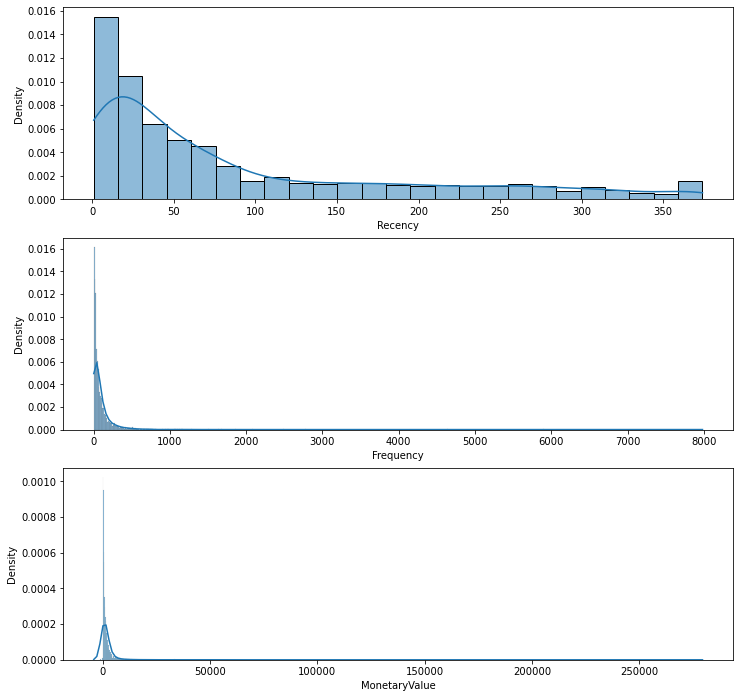

In [12]:
fig, axs = plt.subplots(3, figsize=(12,12))
sns.histplot(rfm_vals['Recency'], 
             kde=True, 
             stat='density',
             ax=axs[0])
sns.histplot(rfm_vals['Frequency'], 
             kde=True,
             stat='density',
             ax=axs[1])
sns.histplot(rfm_vals['MonetaryValue'], 
             kde=True,
             stat='density',
             ax=axs[2])
plt.show()

Highly skewed data, particularly in terms of Frequency and Value

#### Create quantiles for Recency and Frequency

In [13]:
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)


r_groups = pd.qcut(rfm_vals['Recency'], 
                   q=4, 
                   labels=r_labels)

f_groups = pd.qcut(rfm_vals['Frequency'], 
                   q=4, 
                   labels=f_labels)

m_groups = pd.qcut(rfm_vals['MonetaryValue'], 
                   q=4, 
                   labels=f_labels)

rfm_vals = rfm_vals.assign(R = r_groups.values,
                           F = f_groups.values, 
                           M = m_groups.values)

In [14]:
rfm_vals.head()

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346.0,326,2,0.00,1,1,1
12347.0,2,182,4310.00,4,4,4
12348.0,75,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,310,17,334.40,1,1,2


#### Concat to RFM

In [15]:
def concat_rfm(x):
    return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
rfm_vals['RFM_concat'] = rfm_vals.apply(concat_rfm,
                                        axis=1)

In [16]:
rfm_vals.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_concat
CustomerID,,,,,,,
12346.0,326,2,0.00,1,1,1,111
12347.0,2,182,4310.00,4,4,4,444
12348.0,75,31,1797.24,2,2,4,224
12349.0,19,73,1757.55,3,3,4,334
12350.0,310,17,334.40,1,1,2,112


In [17]:
rfm_vals.RFM_concat.nunique()

62

In [18]:
rfm_vals['RFM_Score'] = rfm_vals[['R', 'F', 'M']].sum(axis=1)
rfm_vals.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_concat,RFM_Score
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3
12347.0,2,182,4310.00,4,4,4,444,12
12348.0,75,31,1797.24,2,2,4,224,8
12349.0,19,73,1757.55,3,3,4,334,10
12350.0,310,17,334.40,1,1,2,112,4


In [19]:
# Define RFM Levels
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Lose Them'
    elif 9 > df['RFM_Score'] >= 8:
        return 'Champions'
    elif 8 > df['RFM_Score'] >= 7:
        return 'Loyal'
    elif 7 > df['RFM_Score'] >= 6:
        return 'Potential'
    elif 6 > df['RFM_Score'] >= 5:
        return 'Promising'
    elif 5 > df['RFM_Score'] >= 4:
        return 'Needs Attention'
    else:
        return 'Require Activation'
rfm_vals['RFM_Level'] = rfm_vals.apply(rfm_level,
                                        axis=1)
rfm_vals.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_concat,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3,Require Activation
12347.0,2,182,4310.00,4,4,4,444,12,Can't Lose Them
12348.0,75,31,1797.24,2,2,4,224,8,Champions
12349.0,19,73,1757.55,3,3,4,334,10,Can't Lose Them
12350.0,310,17,334.40,1,1,2,112,4,Needs Attention


#### Grouping by RFM

In [20]:
rfm_vals

,Recency,Frequency,MonetaryValue,R,F,M,RFM_concat,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3,Require Activation
12347.0,2,182,4310.00,4,4,4,444,12,Can't Lose Them
12348.0,75,31,1797.24,2,2,4,224,8,Champions
12349.0,19,73,1757.55,3,3,4,334,10,Can't Lose Them
12350.0,310,17,334.40,1,1,2,112,4,Needs Attention
...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111,3,Require Activation
18281.0,181,7,80.82,1,1,1,111,3,Require Activation
18282.0,8,13,176.60,4,1,1,411,6,Potential


In [21]:
rfm_groupings = rfm_vals.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

In [22]:
rfm_groupings

Recency Frequency MonetaryValue      
                      mean      mean          mean count
RFM_Level                                               
Can't Lose Them       25.2     195.1        4130.3  1690
Champions             62.7      57.0         974.7   467
Loyal                 78.8      39.7         724.2   447
Needs Attention      174.5      13.9         227.1   391
Potential             94.3      28.5         491.8   468
Promising            153.0      21.2         346.8   517
Require Activation   264.8       7.8         109.1   392

Note, Have not seen Needs Attention in a while, provide promo to bring back? Incentivize larger shopping carts? given low Monetary?
Potential very close to Loyal, but need to boost Monetary, promotion based on cart size?
Promising, need to bring back to buying, target discount on previously browsed products.

In [23]:
rfm_groupings.columns.droplevel()

Index(['mean', 'mean', 'mean', 'count'], dtype='object')

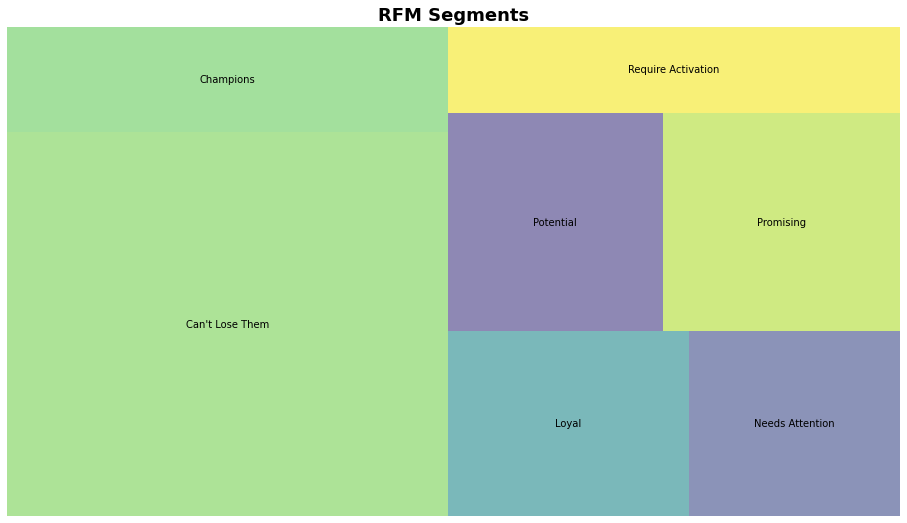

In [24]:
rfm_groupings.columns = rfm_groupings.columns.droplevel()
rfm_groupings.columns = ['RecencyMean',
                         'FrequencyMean',
                         'MonetaryMean',
                         'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_groupings['Count'], 
              label=rfm_groupings.index, alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()